## Benchmarking Tool-using Agentic Approach

* After exploring a variety of possible benchmarks, I decided to focus on SemScore, which is a semantic similarity metric. 
* The idea is to evaluate how well the agent can answer questions that are syntactically and semantically similar to the reference answers.
* One challenge is that, because I chose to 

In [1]:
import os
import numpy as np
import pandas as pd
from transformers.agents import agent_types
from tqdm.notebook import tqdm
import logging
from IPython.display import Markdown
from semscore import EmbeddingModelWrapper
from statistics import mean
from agent import get_agent
from dotenv import load_dotenv
from prompts import SUCCINCT_SQUAD_REACT_CODE_SYSTEM_PROMPT, FOCUSED_SQUAD_REACT_CODE_SYSTEM_PROMPT

load_dotenv()  # Load OPENAI_API_KEY from .env (not included in repo)

SAMPLES_DIR = "samples"

def display_text_df(df):
    display(df.style.set_properties(**{'white-space': 'pre-wrap'}).set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'td', 'props': [('text-align', 'left')]}
        ]
    ).hide())


Initializing Data...
Download: True
Loading data...
Raw Data loaded
Chroma DB already exists
Loading index...
Index loaded


In [2]:
from data import get_data
data = get_data(download=False)


In [3]:
data.df.shape

(87599, 4)

In [4]:
display_text_df(data.df.head(3))


Title,Context,Question,Answer
University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,Saint Bernadette Soubirous
University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",What is in front of the Notre Dame Main Building?,a copper statue of Christ
University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",The Basilica of the Sacred heart at Notre Dame is beside to which structure?,the Main Building


In [17]:
np.random.seed(42)
# Select 10 random rows from data.df
dfSample = data.df.sample(n=300)
display_text_df(dfSample.head())

Title,Context,Question,Answer
Institute_of_technology,"The world's first institution of technology or technical university with tertiary technical education is the Banská Akadémia in Banská Štiavnica, Slovakia, founded in 1735, Academy since December 13, 1762 established by queen Maria Theresa in order to train specialists of silver and gold mining and metallurgy in neighbourhood. Teaching started in 1764. Later the department of Mathematics, Mechanics and Hydraulics and department of Forestry were settled. University buildings are still at their place today and are used for teaching. University has launched the first book of electrotechnics in the world.",What year was the Banská Akadémia founded?,1735
Film_speed,"The standard specifies how speed ratings should be reported by the camera. If the noise-based speed (40:1) is higher than the saturation-based speed, the noise-based speed should be reported, rounded downwards to a standard value (e.g. 200, 250, 320, or 400). The rationale is that exposure according to the lower saturation-based speed would not result in a visibly better image. In addition, an exposure latitude can be specified, ranging from the saturation-based speed to the 10:1 noise-based speed. If the noise-based speed (40:1) is lower than the saturation-based speed, or undefined because of high noise, the saturation-based speed is specified, rounded upwards to a standard value, because using the noise-based speed would lead to overexposed images. The camera may also report the SOS-based speed (explicitly as being an SOS speed), rounded to the nearest standard speed rating.",What is another speed that can also be reported by the camera?,SOS-based speed
Sumer,"The most impressive and famous of Sumerian buildings are the ziggurats, large layered platforms which supported temples. Sumerian cylinder seals also depict houses built from reeds not unlike those built by the Marsh Arabs of Southern Iraq until as recently as 400 CE. The Sumerians also developed the arch, which enabled them to develop a strong type of dome. They built this by constructing and linking several arches. Sumerian temples and palaces made use of more advanced materials and techniques,[citation needed] such as buttresses, recesses, half columns, and clay nails.",Where were the use of advanced materials and techniques on display in Sumer?,Sumerian temples and palaces
"Ann_Arbor,_Michigan","Ann Arbor has a council-manager form of government. The City Council has 11 voting members: the mayor and 10 city council members. The mayor and city council members serve two-year terms: the mayor is elected every even-numbered year, while half of the city council members are up for election annually (five in even-numbered and five in odd-numbered years). Two council members are elected from each of the city's five wards. The mayor is elected citywide. The mayor is the presiding officer of the City Council and has the power to appoint all Council committee members as well as board and commission members, with the approval of the City Council. The current mayor of Ann Arbor is Christopher Taylor, a Democrat who was elected as mayor in 2014. Day-to-day city operations are managed by a city administrator chosen by the city council.",Who is elected every even numbered year?,mayor
John_von_Neumann,"Shortly before his death, when he was already quite ill, von Neumann headed the United States government's top secret ICBM committee, and it would sometimes meet in his home. Its purpose was to decide on the feasibility of building an ICBM large enough to carry a thermonuclear weapon. Von Neumann had long argued that while the technical obstacles were sizable, they could be overcome in time. The SM-65 Atlas passed its first fully functional test in 1959, two years after his death. The feasibility of an ICBM owed as much to improved, smaller warheads as it did to developments in rocketry, and his understanding of the former made his advice invaluable.",What was the purpose

In [18]:
# use local gpt to synthesize questions with context

synth_system_prompt = """
You are an expert at clarifying what questions are really asking for.

You will be given a question, a title and context.
Your task is come up with a new version of the question that resolves ambiguities by adding only and exactly the necessary details from the title and context in a way that clarifies the question without changing the meaning or intent of the question.

For example: 
Question: Who does M fight with?
Title: Spectre_(2015_film)
Context: Bond and Swann return to London where they meet M, Bill Tanner, Q, and Moneypenny; they intend to arrest C and stop Nine Eyes from going online. Swann leaves Bond, telling him she cannot be part of a life involving espionage, and is subsequently kidnapped. On the way, the group is ambushed and Bond is kidnapped, but the rest still proceed with the plan. After Q succeeds in preventing the Nine Eyes from going online, a brief struggle between M and C ends with the latter falling to his death. Meanwhile, Bond is taken to the old MI6 building, which is scheduled for demolition, and frees himself. Moving throughout the ruined labyrinth, he encounters a disfigured Blofeld, who tells him that he has three minutes to escape the building before explosives are detonated or die trying to save Swann. Bond finds Swann and the two escape by boat as the building collapses. Bond shoots down Blofeld's helicopter, which crashes onto Westminster Bridge. As Blofeld crawls away from the wreckage, Bond confronts him but ultimately leaves him to be arrested by M. Bond leaves the bridge with Swann.
Response: Who does M struggle with during the events of Spectre (2015)?
"""

synth_user_prompt = """
Question: {question}
Title: {title}
Context: {context}
"""


In [ ]:
# Example: reuse your existing OpenAI setup
from openai import OpenAI

# Point to the local server
# client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
client = OpenAI()

synth_answers = []
for title, context, question, answer in tqdm(dfSample.values):
    completion = client.chat.completions.create(
    # model="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {"role": "system", "content": synth_system_prompt},
        {"role": "user", "content": synth_user_prompt.format(question=question, title=title, context=context)}
    ],
    temperature=0.7,
    )
    synth_answers.append(completion.choices[0].message.content)

dfSample["Synthesized Question"] = synth_answers

In [ ]:
os.makedirs(SAMPLES_DIR, exist_ok=True)
dfSample.to_pickle(os.path.join(SAMPLES_DIR, f"samples.pkl"))    


In [48]:
dfSample = pd.read_pickle(os.path.join(SAMPLES_DIR, f"samples.pkl"))
display_text_df(dfSample.head())
dfSample.shape

Title,Context,Question,Answer,Synthesized Question
Institute_of_technology,"The world's first institution of technology or technical university with tertiary technical education is the Banská Akadémia in Banská Štiavnica, Slovakia, founded in 1735, Academy since December 13, 1762 established by queen Maria Theresa in order to train specialists of silver and gold mining and metallurgy in neighbourhood. Teaching started in 1764. Later the department of Mathematics, Mechanics and Hydraulics and department of Forestry were settled. University buildings are still at their place today and are used for teaching. University has launched the first book of electrotechnics in the world.",What year was the Banská Akadémia founded?,1735,"What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?"
Film_speed,"The standard specifies how speed ratings should be reported by the camera. If the noise-based speed (40:1) is higher than the saturation-based speed, the noise-based speed should be reported, rounded downwards to a standard value (e.g. 200, 250, 320, or 400). The rationale is that exposure according to the lower saturation-based speed would not result in a visibly better image. In addition, an exposure latitude can be specified, ranging from the saturation-based speed to the 10:1 noise-based speed. If the noise-based speed (40:1) is lower than the saturation-based speed, or undefined because of high noise, the saturation-based speed is specified, rounded upwards to a standard value, because using the noise-based speed would lead to overexposed images. The camera may also report the SOS-based speed (explicitly as being an SOS speed), rounded to the nearest standard speed rating.",What is another speed that can also be reported by the camera?,SOS-based speed,What is another speed rating that can also be reported by the camera in addition to the noise-based and saturation-based speeds?
Sumer,"The most impressive and famous of Sumerian buildings are the ziggurats, large layered platforms which supported temples. Sumerian cylinder seals also depict houses built from reeds not unlike those built by the Marsh Arabs of Southern Iraq until as recently as 400 CE. The Sumerians also developed the arch, which enabled them to develop a strong type of dome. They built this by constructing and linking several arches. Sumerian temples and palaces made use of more advanced materials and techniques,[citation needed] such as buttresses, recesses, half columns, and clay nails.",Where were the use of advanced materials and techniques on display in Sumer?,Sumerian temples and palaces,"Where were the advanced materials and techniques, such as buttresses and arches, used in Sumerian temples and palaces on display?"
"Ann_Arbor,_Michigan","Ann Arbor has a council-manager form of government. The City Council has 11 voting members: the mayor and 10 city council members. The mayor and city council members serve two-year terms: the mayor is elected every even-numbered year, while half of the city council members are up for election annually (five in even-numbered and five in odd-numbered years). Two council members are elected from each of the city's five wards. The mayor is elected citywide. The mayor is the presiding officer of the City Council and has the power to appoint all Council committee members as well as board and commission members, with the approval of the City Council. The current mayor of Ann Arbor is Christopher Taylor, a Democrat who was elected as mayor in 2014. Day-to-day city operations are managed by a city administrator chosen by the city council.",Who is elected every even numbered year?,mayor,"Who is elected as mayor every even-numbered year in Ann Arbor, Michigan?"
John_von_Neumann,"Shortly before his death, when he was already quite ill, von Neumann headed the United States government's top secret ICBM committee, and it would sometimes meet in his home. Its purpose was to decide o

(100, 5)

In [9]:
prompt = "What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?"
agent = get_agent()
agent.run(prompt, stream=False, reset=True)


======== New task ========
What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?
=== Agent thoughts:
Thought: I will use the squad_retriever tool to find the founding year of the Banská Akadémia, which is known as the world's first institution of technology located in Banská Štiavnica, Slovakia. I will craft a detailed query to ensure I retrieve the most relevant information.
>>> Agent is executing the code below:
answer = squad_retriever(query="What year was the Banská Akadémia, the world's first institution of technology, founded in Banská Štiavnica, Slovakia?")
print(answer)
====
Print outputs:
===Document===
Title: Institute_of_technology
Context: The world's first institution of technology or technical university with tertiary technical education is the Banská Akadémia in Banská Štiavnica, Slovakia, founded in 1735, Academy since December 13, 1762 established by queen Maria Theresa in order to train specialists of si

"The Banská Akadémia, the world's first institution of technology, was founded in 1735."

### Create the agent to be evaluated

### Run the agent on the random sample of questions

* Unlike the default Retrieval QA or Open Generative QA of SQuAD, in our use case, the agent would normally be given context in the course of a natural conversation, as the user elaborates on what they want to know. 
* Therefore, for benchmarking, we will provide the context to answer the question in the prompt.

### Use semantic similarity to evaluate the agent's answers against the reference answers

* One flaw of this approach is that it does not take into account the existence of multiple acceptable answers.
* Another flaw is that the agent me be unfairly penalized for elaborating on the answer, while this benchmark focuses on only and exactly the one canonical answer given.


In [49]:
BENCHMARKS_DIR = "benchmarks"

import re
from string import punctuation
from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", punctuation))
    # Remove stop words
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

def benchmark_agent(agent, dfSample, name):
    answers_ref, answers_pred = [], []        

    # Suppress logging from the agent, which can be quite verbose
    agent.logger.setLevel(logging.CRITICAL)

    for title, context, question, answer, synthesized_question in tqdm(dfSample.values):
        class Output:
            output: agent_types.AgentType | str = None

        prompt = synthesized_question
        answers_ref.append(answer)
        final_answer = agent.run(prompt, stream=False, reset=True)
        answers_pred.append(final_answer)

    answers_ref = [str(answer) for answer in answers_ref]
    answers_pred = [str(answer) for answer in answers_pred]

    # Remove stop words and punctuation from answers
    answers_ref = [clean_text(answer) for answer in answers_ref]
    answers_pred = [clean_text(answer) for answer in answers_pred]

    em = EmbeddingModelWrapper()
    similarities = em.get_similarities(
        em.get_embeddings( answers_pred ),
        em.get_embeddings( answers_ref ),
    )

    dfAnswers = dfSample.copy()
    dfAnswers["Predicted Answer"] = answers_pred
    dfAnswers["Similarity"] = similarities

    os.makedirs(BENCHMARKS_DIR, exist_ok=True)
    dfAnswers.to_pickle(os.path.join(BENCHMARKS_DIR, f"{name}.pkl"))


### Set up and run the benchmarks

In [50]:
benchmarks = [
    (get_agent(), "baseline"), # Baseline agent with default settings
    (get_agent(system_prompt=SUCCINCT_SQUAD_REACT_CODE_SYSTEM_PROMPT), "succinct"), # Succinct agent
    (get_agent(system_prompt=FOCUSED_SQUAD_REACT_CODE_SYSTEM_PROMPT), "focused"), # Focused agent
]

for agent, name in tqdm(benchmarks):
    benchmark_agent(agent, dfSample, name)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
# Load and display all benchmarks
def load_benchmarks():
    benchmarks_dir = "benchmarks"
    benchmarks = []
    for file in os.listdir(benchmarks_dir):
        if file.endswith(".pkl"):
            df = pd.read_pickle(os.path.join(benchmarks_dir, file))
            benchmarks.append({
                'name': file.replace(".pkl", ""),
                'data': df, 
            })
    return benchmarks

benchmarks = load_benchmarks()

# Add mean similarity to each benchmark
for benchmark in benchmarks:
    benchmark['mean_similarity'] = benchmark['data']['Similarity'].mean()

# Sort benchmarks by mean similarity
benchmarks.sort(key=lambda x: x['mean_similarity'], reverse=False)

from sklearn.metrics import roc_curve
for benchmark in benchmarks:
    display(Markdown(f"## {benchmark['name']}"))
    display(Markdown(f"#### Mean similarity: {round(benchmark['mean_similarity'], 2)}"))

    # Count the number of rows where the similarity score is less than 0.9
    num_low_similarity = len(benchmark['data'][benchmark['data']['Similarity'] < 0.9])
    display(Markdown(f"#### Number of rows with similarity score less than 0.9: {num_low_similarity}"))
    # df = benchmark['data'][benchmark['data']['Similarity'] < 0.9]
    # display_text_df(df[['Synthesized Question', 'Answer', 'Predicted Answer', 'Similarity']])

    # For thresholds from 0.5 to 0.99, count the number of rows where the similarity score is less than the threshold
    thresholds = np.arange(0.1, 0.9, 0.01)
    num_rows_below_threshold = []
    for threshold in thresholds:
        num_rows_below_threshold.append(len(benchmark['data'][benchmark['data']['Similarity'] < threshold]))
    benchmark['num_rows_below_threshold'] = num_rows_below_threshold

    # Considering 1-Similarity as error
    error = 1 - benchmark['data']['Similarity']
    # Calculate Root Mean Squared Error(RMSE)
    rmse = np.sqrt(np.mean(np.square(error)))
    display(Markdown(f"#### Root Mean Squared Error: {round(rmse, 2)}"))
    # Calculate Root Mean Squared Log Error(RMSLE)
    rmsle = np.sqrt(np.mean(np.square(np.log1p(error))))
    display(Markdown(f"#### Root Mean Squared Log Error: {round(rmsle, 2)}"))

## baseline

#### Mean similarity: 0.48

#### Number of rows with similarity score less than 0.9: 98

#### Root Mean Squared Error: 0.57

#### Root Mean Squared Log Error: 0.44

## succinct

#### Mean similarity: 0.83

#### Number of rows with similarity score less than 0.9: 37

#### Root Mean Squared Error: 0.31

#### Root Mean Squared Log Error: 0.24

## focused

#### Mean similarity: 0.86

#### Number of rows with similarity score less than 0.9: 31

#### Root Mean Squared Error: 0.27

#### Root Mean Squared Log Error: 0.21

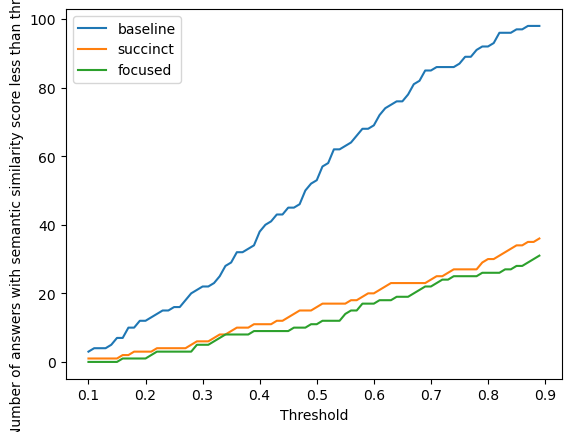

In [53]:
# Plot the number of rows below each threshold, for each benchmark on the same plot
import matplotlib.pyplot as plt
for benchmark in benchmarks:
    plt.plot(thresholds, benchmark['num_rows_below_threshold'], label=benchmark['name'])
plt.xlabel('Threshold')
plt.ylabel('Number of answers with semantic similarity score less than threshold')
plt.legend()
plt.show()


In [56]:
# Show the worst 10 answers for each benchmark
for benchmark in benchmarks:
    display(Markdown(f"## Worse scoring answers for {benchmark['name']}"))
    # Rename columns
    df = benchmark['data'].rename(columns={
        'Answer': 'Cleaned Answer',
        'Predicted Answer': 'Cleaned Predicted Answer'
    })
    display_text_df(df[['Synthesized Question', 'Cleaned Answer', 'Cleaned Predicted Answer', 'Similarity']].sort_values(by='Similarity', ascending=True).head(10))


## Worse scoring answers for baseline

Synthesized Question,Cleaned Answer,Cleaned Predicted Answer,Similarity
"How many species of fungi, both non-lichen-forming and lichen-forming, have been recorded in Antarctica?",1150,1150 species fungi recorded antarctica including approximately 750 nonlichenforming 400 lichenforming species,-0.037171
"What fraction of the South Florida population lives in the city of Miami, given that it is home to less than one-thirteenth of the population of South Florida?",one-thirteenth,fraction south florida population lives city miami less 113,-0.003697
In how many scenarios projected by the ABS will Sydney remain higher than Melbourne in population beyond 2056?,two,two scenarios projected abs sydney remain higher melbourne population beyond 2056,0.075540
How many companies were involved in the development of USB in 1994?,seven,seven companies involved development usb 1994,0.108814
"What kind of nutritional value do processed foods have in comparison to their fresh variants, considering the impact of processing techniques on nutrient content as described in the context of nutrition?",reduced,processed foods generally reduced nutritional value compared fresh foods superior nutrient content processing techniques lead loss essential nutrients often result addition harmful substances,0.138965
On what date did ESPN announce the purchase of a minority stake in the Arena Football League (AFL)?,"December 19, 2006",espn announced purchase minority stake arena football league december 19 2006,0.143321
What term did Europeans use to refer to the Ottoman Empire during the mid-19th century?,"the ""sick man""",term europeans used refer ottoman empire mid19th century sick man europe,0.148575
"What does the Sanskrit term ""Karma,"" which translates to ""action"" or ""work,"" refer to in the context of Buddhism?","action, work",buddhism sanskrit term karma refers force drives saṃsāra cycle suffering rebirth encompasses actions body speech mind arise mental intent lead consequences either life future rebirths good actions encouraged unwholesome actions avoided,0.160409
How many civilians died in the attack on the Vilnius TV Tower during the events leading up to the dissolution of the Soviet Union?,Fourteen,fourteen unarmed civilians died attack vilnius tv tower events leading dissolution soviet union,0.164086
"At around what age, specifically twenty-four or twenty-five, was Dominic ordained as a Priest in the context of the Dominican Order?",twenty-five,dominic ordained priest age twentyfive,0.165672


## Worse scoring answers for succinct

Synthesized Question,Cleaned Answer,Cleaned Predicted Answer,Similarity
"How many species of fungi, both non-lichen-forming and lichen-forming, have been recorded in Antarctica?",1150,1150 species fungi recorded antarctica,-0.002039
Where was very expensive wallpaper imported from during the Georgian architectural period?,China,could find information origins expensive wallpaper georgian architectural period,0.154515
"What kind of nutritional value do processed foods have in comparison to their fresh variants, considering the impact of processing techniques on nutrient content as described in the context of nutrition?",reduced,processed foods reduced nutritional value compared fresh foods,0.174138
"According to Hayek, limited government power through the Rule of Law does not stultify individual efforts by ad hoc action. What does this mean for people's ability to make investments and future plans?",frustrate his efforts,according hayek limited government power rule law enables individuals confidently make investments future plans without fear government interference could frustrate efforts,0.212996
"What does the Sanskrit term ""Karma,"" which translates to ""action"" or ""work,"" refer to in the context of Buddhism?","action, work",buddhism karma refers force drives saṃsāra encompassing actions body speech mind spring mental intent producing consequences,0.277542
"Who is elected as mayor every even-numbered year in Ann Arbor, Michigan?",mayor,christopher taylor,0.288215
How many copies has Queen's Greatest Hits II sold worldwide?,16 million,sales figures queens greatest hits ii specifically available queen sold 150 million records worldwide,0.315704
"When did Tajiks begin to be conscripted into the Soviet Army, particularly during the lead-up to and including World War II?",1939,tajiks began conscripted soviet army 1939,0.329918
What impact does temperature have on the variability of hunter-gatherer tool kits?,increased variability of tools,temperature increases variability huntergatherer tool kits,0.341771
What was the typical shape and size of town terraced houses during the Georgian architecture period?,tall and narrow,town terraced houses georgian architecture period typically tall narrow,0.359480


## Worse scoring answers for focused

Synthesized Question,Cleaned Answer,Cleaned Predicted Answer,Similarity
"What kind of nutritional value do processed foods have in comparison to their fresh variants, considering the impact of processing techniques on nutrient content as described in the context of nutrition?",reduced,processed foods generally reduced nutritional value compared fresh foods,0.156578
Where was very expensive wallpaper imported from during the Georgian architectural period?,China,georgian architectural period expensive wallpaper primarily imported france china french wallpapers particularly made intricate designs luxurious materials highly sought wealthy elite britain additionally chinese wallpapers often featuring elaborate patterns rich colors became popular time well importation wallpapers reflected trends interior design desire opulence among upper classes georgian society,0.206612
"According to Hayek, limited government power through the Rule of Law does not stultify individual efforts by ad hoc action. What does this mean for people's ability to make investments and future plans?",frustrate his efforts,according hayek limited government power rule law allows individuals make wise investments future plans confidence prevents government frustrating efforts,0.218238
"What does the Sanskrit term ""Karma,"" which translates to ""action"" or ""work,"" refer to in the context of Buddhism?","action, work",buddhism karma refers force drives saṃsāra involving actions body speech mind spring mental intent produce consequences,0.282605
"Who is elected as mayor every even-numbered year in Ann Arbor, Michigan?",mayor,christopher taylor,0.288215
What impact does temperature have on the variability of hunter-gatherer tool kits?,increased variability of tools,temperature leads increased variability huntergatherer tool kits,0.314088
"When did Tajiks begin to be conscripted into the Soviet Army, particularly during the lead-up to and including World War II?",1939,tajiks began conscripted soviet army 1939,0.329919
"What are the implications of measuring heterosexuality and homosexuality on separate scales instead of the same scale, as discussed in the context of the Kinsey scale in the study of sexual orientation?","they act as tradeoffs such, whereby to be more feminine one had to be less masculine and vice versa",measuring heterosexuality homosexuality separate scales allows independent determination orientations enabling individuals identify heterosexual homosexual simultaneously,0.330656
"What is the size of the Matthaei Botanical Gardens located in Ann Arbor, Michigan?",300 acres,matthaei botanical gardens ann arbor michigan covers area approximately 300 acres,0.385660
What term did Europeans use to refer to the Ottoman Empire during the mid-19th century?,"the ""sick man""",sick man europe,0.451294
